In [1]:
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

from feature_engineering.player_awareness import PlayerAwarenessCalculator
from feature_engineering.player_influence import PlayerInfluenceCalculator

pd.options.display.max_columns = None

In [2]:
vis_data = pd.read_csv("data/visualization_decoy_data_week_9.csv")
games = pd.read_csv('data/games.csv')
player_play = pd.read_csv('data/player_play.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tracking_data = pd.read_csv("data/tracking_week_9.csv")

In [3]:
# Flip plays to ensure all plays are from left to right
tracking_data['x'] = tracking_data.apply(lambda row: 120 - row['x'] if row['playDirection'] == 'left' else row['x'], axis=1)
tracking_data['dir'] = tracking_data.apply(lambda row: (- row['dir'] + 360) % 360 if row['playDirection'] == 'left' else row['dir'], axis=1)
tracking_data['o'] = tracking_data.apply(lambda row: (- row['o'] + 360) % 360 if row['playDirection'] == 'left' else row['o'], axis=1)

tracking_data = tracking_data.merge(plays[['gameId', 'playId', 'absoluteYardlineNumber']], on=['gameId', 'playId'], how='inner')
tracking_data['absoluteYardlineNumber'] = tracking_data.apply(lambda row: 120 - row['absoluteYardlineNumber'] if row['playDirection'] == 'left' else row['absoluteYardlineNumber'], axis=1)

In [4]:
potential_ball_carrier_classifier = XGBClassifier()
potential_ball_carrier_classifier.load_model("models/potential_ball_carrier_predictor.json")

play_type_classifier = XGBClassifier()
play_type_classifier.load_model("models/play_type_predictor.json")

blocker_classifier = XGBClassifier()
blocker_classifier.load_model("models/blocker_predictor.json")

In [5]:
features = [
    'voronoi_area', 'distance_to_qb', 'distance_to_ball', 'defender_influence',
    'teammate_influence', 'defender_awareness', 'teammate_awareness',
    'qb_awareness', 'closest_defender_awareness', 'second_closest_defender_awareness', 
    'closest_teammate_awareness', 'second_closest_teammate_awareness', 
    'closest_defender_distance', 'second_closest_defender_distance', 
    'closest_defender_speed', 'second_closest_defender_speed', 
    'closest_teammate_distance', 'second_closest_teammate_distance', 
    'closest_teammate_speed', 'second_closest_teammate_speed', 'player_speed',
    'relative_x_speed_to_closest_defender', 'relative_x_speed_to_second_closest_defender',
    'relative_y_speed_to_closest_defender', 'relative_y_speed_to_second_closest_defender',
    'relative_x_speed_to_closest_teammate', 'relative_x_speed_to_second_closest_teammate',
    'relative_y_speed_to_closest_teammate', 'relative_y_speed_to_second_closest_teammate', 
    'distance_to_los', 'y_position', 
    ]

ball_carrier_features = ['distance_to_ball', 'distance_to_qb', 'distance_to_los', 'second_closest_teammate_distance', 'closest_defender_distance', 'closest_teammate_distance', 'qb_awareness', 'player_speed', 'y_position', 'teammate_awareness']
blocker_features = ['distance_to_ball', 'distance_to_qb', 'second_closest_teammate_distance', 'closest_teammate_distance', 'distance_to_los', 'qb_awareness', 'y_position', 'second_closest_defender_distance', 'teammate_awareness', 'defender_influence']
play_type_features = ['distance_to_los', 'distance_to_qb', 'defender_influence', 'second_closest_teammate_distance', 'qb_awareness', 'closest_defender_distance', 'distance_to_ball', 'teammate_influence', 'second_closest_defender_distance', 'y_position']

In [6]:
vis_data['ball_carrier_probability'] = potential_ball_carrier_classifier.predict_proba(vis_data[ball_carrier_features])[:, 1]
vis_data['pass_probability'] = play_type_classifier.predict_proba(vis_data[play_type_features])[:, 1]
vis_data['receiver_probability'] = vis_data.apply(lambda x: x.pass_probability * x.ball_carrier_probability, axis = 1)
vis_data['rusher_probability'] = vis_data.apply(lambda x: (1 - x.pass_probability) * x.ball_carrier_probability, axis = 1)
vis_data['blocker_probability'] = blocker_classifier.predict_proba(vis_data[blocker_features])[:, 1]

In [7]:
def get_play_data(game_id, play_id):
    play_data = vis_data[(vis_data.gameId == game_id) & (vis_data.playId == play_id)].sort_values(['frameId', 'nflId'])

    play_tracking_data = tracking_data[(tracking_data.gameId == game_id) & (tracking_data.playId == play_id)]
    play_tracking_data = play_tracking_data.merge(
        play_data[['gameId', 'playId', 'nflId', 'frameId', 'ball_carrier_probability', 'pass_probability', 'receiver_probability', 'rusher_probability', 'blocker_probability']],
        on=['gameId', 'playId', 'nflId', 'frameId'], how='left'
    )

    return play_tracking_data

In [8]:
# Extract a single play data
# game_id, play_id = 2022110300, 647
game_id = 2022110606
play_id = 2653

### 00 - Framework Visualization

In [ ]:
# Replace with actual data retrieval functions and IDs
play_tracking_data = get_play_data(game_id=game_id, play_id=play_id)
play_tracking_data = play_tracking_data[play_tracking_data.frameType != "AFTER_SNAP"]
frames = np.sort(play_tracking_data.frameId.unique())

# Identify the offensive team
offense_team = play_tracking_data.loc[~play_tracking_data['ball_carrier_probability'].isna(), 'club'].unique()[0]

# Create subplots for blocker, rusher, and receiver probabilities
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=600, sharey=True)
probability_types = ['blocker_probability', 'rusher_probability', 'receiver_probability']
cmap_names = ['Blues', 'Reds', 'Greens']
titles = ['Blocker Probability', 'Rusher Probability', 'Receiver Probability']

# Initialize scatter plots and colorbars for each subplot
scatters = []
defense_scatters = []
ball_scatters = []
colorbars = []

for ax, prob_type, cmap_name, title in zip(axes, probability_types, cmap_names, titles):
    # Set up the field visualization
    ax.set_xlim(53.3, 0)  # Field width becomes the x-axis
    ax.set_ylim(55, 75)  # Crop field length to 55-75 yards

    # Add field markings
    for y in range(0, 130, 10):
        ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.9)

    # Add yardline marking
    absolute_yardline = play_tracking_data.loc[0, 'absoluteYardlineNumber']
    if 55 <= absolute_yardline <= 75:  # Only display if within cropped range
        ax.axhline(y=absolute_yardline, color='gray', linestyle='--', label='Yardline')

    # Add labels and title
    ax.set_xlabel("Field Width (yards)")
    ax.set_title(title, fontsize=12, weight='bold')

    # Normalize probabilities for colormap
    norm = plt.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap(cmap_name)

    # Initialize scatter plot for offense
    sc = ax.scatter([], [], c=[], cmap=cmap, norm=norm, edgecolor='black', linewidths=0.75, s=50)
    scatters.append(sc)

    # Initialize scatter plot for defense
    defense_sc = ax.scatter([], [], color='yellow', edgecolor='black', linewidths=0.75, s=50)
    defense_scatters.append(defense_sc)

    # Initialize scatter plot for ball
    ball_sc = ax.scatter([], [], color='grey', edgecolor='black', linewidths=0.75, s=20)
    ball_scatters.append(ball_sc)

    # Add colorbar
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f'{title}', fontsize=10, weight='bold')
    colorbars.append(cbar)

axes[0].set_ylabel("Field Length (yards)")

# Add text for elapsed time
time_text = fig.text(0.1, 0.02, '', fontsize=12, weight='bold')

# Animation update function
def update(frame):
    # Use the last valid frame data for extended frames
    if frame == frames[-1]:
        frame_data = play_tracking_data[play_tracking_data.frameId == frames[-1]]
        # Assign probabilities from the second-to-last frame to the last frame
        second_last_frame_data = play_tracking_data[play_tracking_data.frameId == frames[-2]]
        frame_data = frame_data.merge(
            second_last_frame_data[['nflId'] + probability_types],
            on='nflId',
            suffixes=('', '_from_second_last'),
            how='left'
        )
        # Replace probabilities in the last frame with those from the second-to-last frame
        for prob_type in probability_types:
            frame_data[prob_type] = frame_data[f"{prob_type}_from_second_last"].fillna(frame_data[prob_type])
    else:
        frame_data = play_tracking_data[play_tracking_data.frameId == frame]

    for scatter, defense_scatter, ball_scatter, prob_type in zip(scatters, defense_scatters, ball_scatters, probability_types):
        # Update offense positions and probabilities
        offense_data = frame_data[frame_data['club'] == offense_team]
        offense_positions = offense_data[['y', 'x']].values  # Swap x and y for rotation
        probabilities = offense_data[prob_type].fillna(0).values  # Ensure probabilities are non-NaN

        # Update defense positions
        defense_data = frame_data[(frame_data['club'] != offense_team) & (~frame_data['nflId'].isna())]
        defense_positions = defense_data[['y', 'x']].values

        # Update ball position
        ball_data = frame_data[frame_data['nflId'].isna()]
        ball_position = ball_data[['y', 'x']].values

        # Update scatter data
        scatter.set_offsets(offense_positions)
        scatter.set_array(probabilities)  # Update probabilities
        scatter.set_clim(0, 1)  # Explicitly set colormap limits for consistency

        defense_scatter.set_offsets(defense_positions)
        ball_scatter.set_offsets(ball_position)

    # Update time text
    elapsed_time = (frame - frames[0]) * 0.1  # Each frame represents 0.1 seconds
    time_text.set_text(f"Time: {elapsed_time:.1f}s{'' if frame < frames.max() else ' (SNAP)'}")

# Extended frames generator
def extended_frames():
    for frame in frames:
        yield frame
    # Repeat the last frame for the pause duration
    for _ in range(int(1000 / 100)):  # 1000ms pause divided by frame interval (100ms)
        yield frames[-1]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=extended_frames(), interval=100, repeat=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save(f"figures/00_basic_play_{game_id}_{play_id}.gif", fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer for GIF

plt.tight_layout()
plt.show()

### 01 - Player Awareness & Influence

In [9]:
# Placeholder for data retrieval
play_tracking_data = get_play_data(game_id=game_id, play_id=play_id)
play_tracking_data = play_tracking_data[play_tracking_data.frameType != "AFTER_SNAP"]
play_tracking_data = play_tracking_data.merge(players, on='nflId', how='left')
frames = np.sort(play_tracking_data.frameId.unique())

# Identify the offensive team
offense_team = play_tracking_data.loc[~play_tracking_data['ball_carrier_probability'].isna(), 'club'].unique()[0]

# Define QB and Influence Calculators
pa = PlayerAwarenessCalculator()
pc = PlayerInfluenceCalculator()

# Prepare the grid for contour plots
x = np.linspace(0, 120, 200)
y = np.linspace(0, 53.3, 200)
X, Y = np.meshgrid(x, y)

# Identify the QB
qb_data = play_tracking_data[play_tracking_data['position'] == 'QB']
qb_id = qb_data['nflId'].iloc[0]  # Assuming one QB per play

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=600)
axes[0].set_title("QB Player Awareness", fontsize=14, weight='bold')
axes[1].set_title("Player Influence", fontsize=14, weight='bold')

# Add field dimensions and endzones
for ax in axes:
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    for _ in np.arange(0, 130, 10):
        ax.axvline(x=_, color='lightgray', linestyle='--', linewidth=0.7)
    ax.set_xlabel("Field Length (yards)")
    ax.set_ylabel("Field Width (yards)")

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Offense', markerfacecolor='white', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Defense', markerfacecolor='yellow', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Ball', markerfacecolor='grey', markersize=10, markeredgecolor='black'),
]
axes[1].legend(handles=legend_elements, loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), frameon=False)

# Initialize scatter plots
offense_scatter = [ax.scatter([], [], color='white', edgecolor='black', s=50, zorder=5) for ax in axes]
defense_scatter = [ax.scatter([], [], color='yellow', edgecolor='black', s=50, zorder=5) for ax in axes]
football_scatter = [ax.scatter([], [], color='grey', edgecolor='black', s=20, zorder=5) for ax in axes]

# Initialize contour plots
contour_qb = axes[0].contourf(X, Y, np.zeros_like(X), cmap='Greens', vmin=0, vmax=1, levels=1000)
contour_influence = axes[1].contourf(X, Y, np.zeros_like(X), cmap='coolwarm', levels=1000)  # Increase levels for smoother gradient

# Add text for elapsed time
time_text = fig.text(0.1, 0.02, '', fontsize=12, weight='bold')

# Animation update function
def update(frame):
    global contour_qb, contour_influence
    frame_data = play_tracking_data[play_tracking_data.frameId == frame]

    # Offense, defense, and ball positions
    offense_positions = frame_data[frame_data['club'] == offense_team][['x', 'y']].values
    defense_positions = frame_data[(frame_data['club'] != offense_team) & (~frame_data['nflId'].isna())][['x', 'y']].values
    ball_position = frame_data[frame_data['nflId'].isna()][['x', 'y']].values

    # Update scatter plots
    for scatter, positions in zip(offense_scatter, [offense_positions] * 2):
        scatter.set_offsets(positions)
    for scatter, positions in zip(defense_scatter, [defense_positions] * 2):
        scatter.set_offsets(positions)
    for scatter, positions in zip(football_scatter, [ball_position] * 2):
        scatter.set_offsets(positions)

    # Update time text
    elapsed_time = (frame - frames[0]) * 0.1  # Each frame represents 0.1 seconds
    time_text.set_text(f"Time: {elapsed_time:.1f}s{'' if frame < frames.max() else ' (SNAP)'}")

    # QB Player Awareness
    qb_frame_data = frame_data[frame_data['nflId'] == qb_id]
    if not qb_frame_data.empty:
        qb_x, qb_y, qb_orientation, qb_speed = qb_frame_data[['x', 'y', 'o', 's']].iloc[0]
        awareness = np.array([[pa.calculate_awareness(qb_x, qb_y, qb_orientation, qb_speed, x, y) for x in X[0]] for y in Y[:, 0]])
        for coll in contour_qb.collections[:]:
            coll.remove()
        contour_qb = axes[0].contourf(X, Y, awareness, cmap='Greens', vmin=0, vmax=1, levels=1000)

    # Player Influence
    influence = np.zeros_like(X)
    for _, player in frame_data.iterrows():
        if not np.isnan(player.nflId):
            influence += pc.calculate_influence(player.x, player.y, player.o, player.dir, player.s, X, Y) * (1 if player.club == offense_team else -1)
    for coll in contour_influence.collections[:]:
        coll.remove()
    contour_influence = axes[1].contourf(X, Y, influence, cmap='coolwarm', levels=1000)  # Ensure smoother gradient

def extended_frames():
    for frame in frames:
        yield frame
    # Repeat the last frame for the pause duration
    for _ in range(int(1000 / 100)):  # 1000ms pause divided by frame interval (100ms)
        yield frames[-1]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=extended_frames(), interval=100, repeat=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save(f"figures/01_player_features_{game_id}_{play_id}.gif", fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer for GIF

plt.tight_layout()
plt.show()

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).
C:\Users\Simeel\AppData\Local\Temp\ipykernel_23648\3820847736.py:109: UserWarning: frames=<generator object extended_frames at 0x000002E60B7E2A40> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, frames=extended_frames(), interval=100, repeat=True, repeat_delay=1000)
C:\Users\Simeel\AppData\Local\Temp\ipykernel_23648\3820847736.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for coll in contour_qb.collection

### Models In Action

In [26]:
game_id = 2022110610
play_id = 3524

C:\Users\Simeel\AppData\Local\Temp\ipykernel_32528\3095899693.py:162: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  player_data['blocker_probability'] = player_data['blocker_probability'].fillna(method='ffill')
C:\Users\Simeel\AppData\Local\Temp\ipykernel_32528\3095899693.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['blocker_probability'] = player_data['blocker_probability'].fillna(method='ffill')
C:\Users\Simeel\AppData\Local\Temp\ipykernel_32528\3095899693.py:163: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  player_data['receiver_probability'] = pl

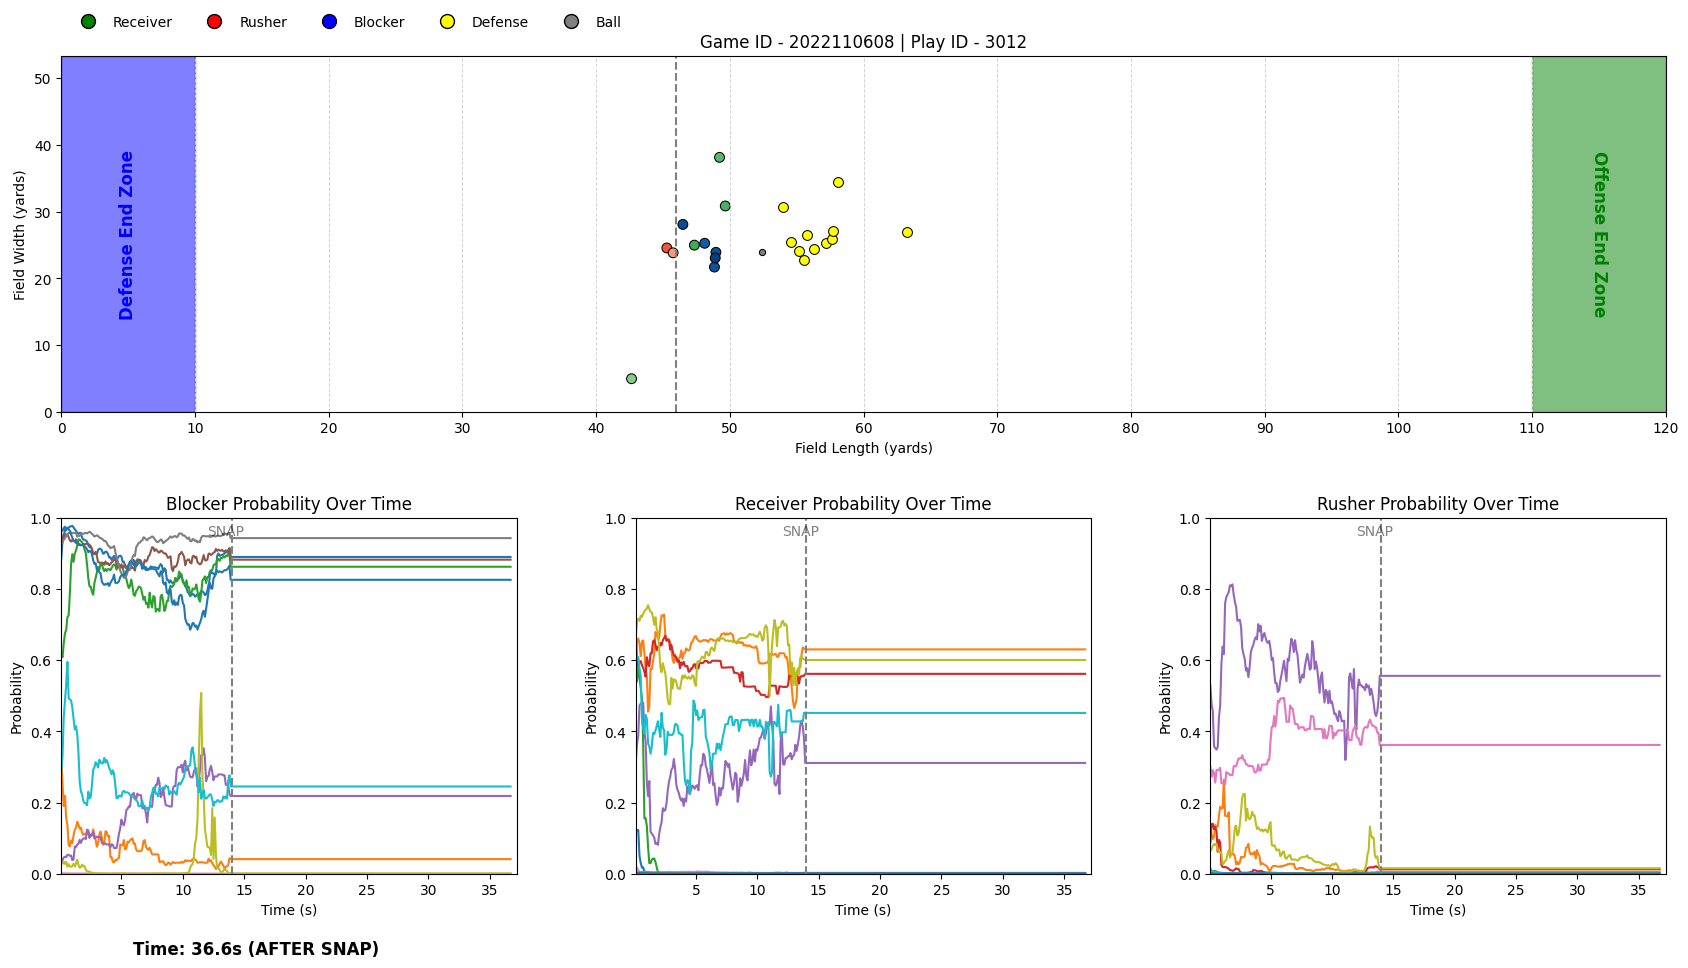

: 

In [ ]:
# Replace these with actual data retrieval functions and IDs
play_tracking_data = get_play_data(game_id=game_id, play_id=play_id)

# Snap frame
snap_frame = play_tracking_data[play_tracking_data.frameType == 'SNAP'].frameId.unique()[0]

# Identify the offensive team
offense_team = play_tracking_data.loc[~play_tracking_data['ball_carrier_probability'].isna(), 'club'].unique()[0]
offense_players = play_tracking_data[play_tracking_data.club == offense_team].nflId.unique()
absolute_yardline = play_tracking_data.loc[0, 'absoluteYardlineNumber']

# Prepare figure with 4 subplots: 1 on top and 3 on the bottom
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

ax_top = fig.add_subplot(gs[0, :])
ax_bottom1 = fig.add_subplot(gs[1, 0])
ax_bottom2 = fig.add_subplot(gs[1, 1])
ax_bottom3 = fig.add_subplot(gs[1, 2])

# Adjust the padding
fig.tight_layout(pad=5.5)

frames = np.sort(play_tracking_data.frameId.unique())

# Set up the field visualization (top subplot)
ax_top.set_xlim(0, 120)
ax_top.set_ylim(0, 53.3)
for x in range(10, 120, 10):
    ax_top.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.7)
ax_top.axvline(x=absolute_yardline, color='gray', linestyle='--', label='Yardline')
ax_top.set_title(f"Game ID - {game_id} | Play ID - {play_id}")
ax_top.set_xlabel("Field Length (yards)")
ax_top.set_ylabel("Field Width (yards)")
ax_top.set_xticks(ticks=[_ for _ in np.arange(0, 130, 10)])

# Bottom subplots (three new line plots)
ax_bottom1.set_xlim(frames.min() * 0.1, frames.max() * 0.1 + 0.5)
ax_bottom1.set_ylim(0, 1)
ax_bottom1.set_title("Blocker Probability Over Time")
ax_bottom1.set_xlabel("Time (s)")
ax_bottom1.set_ylabel("Probability")

ax_bottom2.set_xlim(frames.min() * 0.1, frames.max() * 0.1 + 0.5)
ax_bottom2.set_ylim(0, 1)
ax_bottom2.set_title("Receiver Probability Over Time")
ax_bottom2.set_xlabel("Time (s)")
ax_bottom2.set_ylabel("Probability")

ax_bottom3.set_xlim(frames.min() * 0.1, frames.max() * 0.1 + 0.5)
ax_bottom3.set_ylim(0, 1)
ax_bottom3.set_title("Rusher Probability Over Time")
ax_bottom3.set_xlabel("Time (s)")
ax_bottom3.set_ylabel("Probability")

# Add a legend to top subplot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Receiver', markerfacecolor='green', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Rusher', markerfacecolor='red', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Blocker', markerfacecolor='blue', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Defense', markerfacecolor='yellow', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Ball', markerfacecolor='grey', markersize=10, markeredgecolor='black'),
]
ax_top.legend(handles=legend_elements, loc='upper left', fontsize=10, bbox_to_anchor=(0, 1.15), frameon=False, ncol=5)

# Initialize line plots for each subplot
lines_bottom1 = {player_id: ax_bottom1.plot([], [], label=f"{int(player_id)}")[0] for player_id in offense_players}
lines_bottom2 = {player_id: ax_bottom2.plot([], [], label=f"{int(player_id)}")[0] for player_id in offense_players}
lines_bottom3 = {player_id: ax_bottom3.plot([], [], label=f"{int(player_id)}")[0] for player_id in offense_players}

# Set snap time for line plots
ax_bottom1.axvline(x=snap_frame * 0.1, ymin=0, ymax=1, color='grey', linestyle='--')
ax_bottom2.axvline(x=snap_frame * 0.1, ymin=0, ymax=1, color='grey', linestyle='--')
ax_bottom3.axvline(x=snap_frame * 0.1, ymin=0, ymax=1, color='grey', linestyle='--')

# Add text for snap time
ax_bottom1.text(x=(snap_frame - 20) * 0.1, y = 0.95, s='SNAP', alpha = 0.5, fontsize = 10)
ax_bottom2.text(x=(snap_frame - 20) * 0.1, y = 0.95, s='SNAP', alpha = 0.5, fontsize = 10)
ax_bottom3.text(x=(snap_frame - 20) * 0.1, y = 0.95, s='SNAP', alpha = 0.5, fontsize = 10)

# Add text for elapsed time
time_text = fig.text(0.1, 0.02, '', fontsize=12, weight='bold')

# Initialize end zone fill
Nx = 40
x = np.linspace(0, 10, Nx)
x2 = np.linspace(110, 120, Nx)
y1 = np.zeros_like(x)
y2 = np.ones_like(x) * 53.3

# Create initial fill_between objects for end zones
endzone_fill_left = ax_top.fill_between(x, y1, y2, color='blue', alpha=0.5)
endzone_fill_right = ax_top.fill_between(x2, y1, y2, color='green', alpha=0.5)

# Add text labels for each end zone
ax_top.text(5, 26.65, "Defense End Zone", color='blue', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
ax_top.text(115, 26.65, "Offense End Zone", color='green', ha='center', va='center', fontsize=12, fontweight='bold', rotation=270)

# Initialize scatter plots for top subplot
offense_scatter = ax_top.scatter([], [], color='white', edgecolor='black', linewidths=0.75, s=50)
defense_scatter = ax_top.scatter([], [], color='yellow', edgecolor='black', linewidths=0.75, s=50)
football_scatter = ax_top.scatter([], [], color='grey', edgecolor='black', linewidths=0.75, s=20)

# Store the previous frame's probabilities (before the snap)
prev_offense_probabilities = {}

# Animation update function
def update(frame):
    frame_data = play_tracking_data[play_tracking_data.frameId == frame]

    # Update offense positions with color based on highest probability
    offense_data = frame_data[frame_data['club'] == offense_team]
    offense_positions = offense_data[['x', 'y']].values
    offense_colors = []

    for _, row in offense_data.iterrows():
        # If we are after the snap frame, use previous frame's probabilities
        if frame >= snap_frame:
            if row['nflId'] in prev_offense_probabilities:
                probabilities = prev_offense_probabilities[row['nflId']]
            else:
                # For the first frame after snap, use the current frame's probabilities
                probabilities = [row['receiver_probability'], row['blocker_probability'], row['rusher_probability']]
        else:
            # Use current frame's probabilities before the snap
            probabilities = [row['receiver_probability'], row['blocker_probability'], row['rusher_probability']]

        max_prob = max(probabilities)

        # Assign color intensity based on the highest probability using colormaps
        if max_prob == probabilities[0]:
            color = cm.Greens(max_prob)  # Green: Receiver
        elif max_prob == probabilities[1]:
            color = cm.Blues(max_prob)   # Blue: Blocker
        else:
            color = cm.Reds(max_prob)    # Red: Rusher
        
        offense_colors.append(color)

        # Update the previous frame's probabilities (for future frames)
        if frame < snap_frame:
            prev_offense_probabilities[row['nflId']] = probabilities

    offense_scatter.set_offsets(offense_positions)
    offense_scatter.set_facecolors(offense_colors)

    # Update defense positions with yellow
    defense_data = frame_data[(frame_data['club'] != offense_team) & (~frame_data['nflId'].isna())]
    defense_positions = defense_data[['x', 'y']].values
    defense_scatter.set_offsets(defense_positions)
    defense_scatter.set_facecolors('yellow')  # Keep defense yellow

    # Update football position
    ball_position = frame_data[frame_data['nflId'].isna()][['x', 'y']].values
    football_scatter.set_offsets(ball_position)

    # Update line plots for probabilities over time (for each player)
    for player_id in offense_players:
        player_data = play_tracking_data[(play_tracking_data.nflId == player_id) & (play_tracking_data.frameId <= frame)]

        # Fill missing values with forward fill method for blocker, receiver, and rusher probabilities
        player_data['blocker_probability'] = player_data['blocker_probability'].fillna(method='ffill')
        player_data['receiver_probability'] = player_data['receiver_probability'].fillna(method='ffill')
        player_data['rusher_probability'] = player_data['rusher_probability'].fillna(method='ffill')
        
        # Update Blocker Probability
        if not player_data.empty and not np.isnan(player_data.iloc[0]['blocker_probability']):
            lines_bottom1[player_id].set_data(frames[frames <= frame] * 0.1, player_data['blocker_probability'].values)

        # Update Receiver Probability
        if not player_data.empty and not np.isnan(player_data.iloc[0]['receiver_probability']):
            lines_bottom2[player_id].set_data(frames[frames <= frame] * 0.1, player_data['receiver_probability'].values)

        # Update Rusher Probability
        if not player_data.empty and not np.isnan(player_data.iloc[0]['rusher_probability']):
            lines_bottom3[player_id].set_data(frames[frames <= frame] * 0.1, player_data['rusher_probability'].values)

    # Dynamically update end zone fills
    path_left = endzone_fill_left.get_paths()[0]
    path_right = endzone_fill_right.get_paths()[0]

    verts_left = path_left.vertices
    verts_right = path_right.vertices

    verts_left[1:Nx + 1, 1] = y2
    verts_left[Nx + 2:-1, 1] = y1[::-1]

    verts_right[1:Nx + 1, 1] = y2
    verts_right[Nx + 2:-1, 1] = y1[::-1]

    # Update time text
    elapsed_time = (frame - frames[0]) * 0.1  # Each frame represents 0.1 seconds
    time_text.set_text(f"Time: {elapsed_time:.1f}s{' (BEFORE SNAP)' if frame < snap_frame else (' (SNAP)' if frame == snap_frame else ' (AFTER SNAP)')}")

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, repeat=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save(f"figures/05_probabilities_{game_id}_{play_id}.gif", fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer for GIF

plt.show()